---
layout: post
title:  Steup LangGraph Studio for AI Agent
date:   2025-09-05
categories: [AI, LangChain, LangGraph]
typora-root-url: /Users/ojitha/GitHub/ojitha.github.io
typora-copy-images-to: ../assets/images/${filename}
---

<style>
/* Styles for the two-column layout */
.image-text-container {
    display: flex; /* Enables flexbox */
    flex-wrap: wrap; /* Allows columns to stack on small screens */
    gap: 10px; /* Space between the image and text */
    align-items: left; /* Vertically centers content in columns */
    margin-bottom: 20px; /* Space below this section */
}

.image-column {
    flex: 1; /* Allows this column to grow */
    min-width: 150px; /* Minimum width for the image column before stacking */
    max-width: 20%; /* Maximum width for the image column to not take up too much space initially */
    box-sizing: border-box; /* Include padding/border in element's total width/height */
}

.text-column {
    flex: 2; /* Allows this column to grow more (e.g., twice as much as image-column) */
    min-width: 300px; /* Minimum width for the text column before stacking */
    box-sizing: border-box;
}

</style>

<div class="image-text-container">
    <div class="image-column">
        <img src="/assets/images/2025-09-05-LangGraph_studio_v2/langgraph_agentic_llm_sketch.svg" alt="Scala basics" width="150" height="150">
    </div>
    <div class="text-column">
<p>
Complete LangGraph Studio setup guide for AI agent development featuring visual debugging, real-time execution monitoring, and hot reloading capabilities. Step-by-step tutorial includes working code examples for building production-ready AI agents with tool integration, state management, conditional routing, and seamless LangSmith tracing for optimized multi-step reasoning processes.
<br/>
✅ Complete UV setup - from installation to project configuration 
<br/>
✅ Working agent example - with tools, state management, and proper routing 
<br/>
✅ Multiple testing methods - Studio UI, Python scripts, and direct API calls 
</p>
    </div>
</div>

<!--more-->

------

* TOC
{:toc}
------

## Introduction

In [1]:
%load_ext dotenv
%dotenv ../../../.env

Import the follwoing required packages

In [2]:
from agents.example1.Example1Agent import graph
from typing import TypedDict, Literal, Annotated, Sequence
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
import operator

Here the agent which is compatible with LangGrap Studio

In [3]:
from IPython.display import Markdown, display

def show_py_file(filepath):
    """Display Python file contents as markdown code block"""
    try:
        with open(filepath, 'r', encoding='utf-8') as file:
            content = file.read()
        
        # Create markdown with python syntax highlighting
        markdown_content = f"```python\n{content}\n```"
        display(Markdown(markdown_content))
    except FileNotFoundError:
        print(f"File not found: {filepath}")
    except Exception as e:
        print(f"Error reading file: {e}")

# Usage
show_py_file('./agents/example1/Example1Agent.py')


```python
from typing import TypedDict, Literal, Annotated, Sequence
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, ToolMessage
import operator

class AgentState(TypedDict):
    messages: Annotated[Sequence[HumanMessage | AIMessage | SystemMessage], operator.add]

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def get_weather(location: str) -> str:
    """Get the current weather for a location."""
    weather_data = {
        "london": "Cloudy with light rain, 15°C",
        "paris": "Sunny and warm, 22°C", 
        "new york": "Partly cloudy, 18°C",
        "tokyo": "Clear skies, 25°C"
    }
    location_lower = location.lower()
    if location_lower in weather_data:
        return f"The weather in {location} is {weather_data[location_lower]}"
    else:
        return f"The weather in {location} is sunny with 20°C (mock data)"

def search_web(query: str) -> str:
    """Search the web for information."""
    return f"Search results for '{query}': Here are some relevant articles and information about {query}. This is mock data - in a real implementation, this would connect to a search API."

def calculate_math(expression: str) -> str:
    """Calculate mathematical expressions safely."""
    try:
        allowed_chars = set('0123456789+-*/().,= ')
        if all(c in allowed_chars for c in expression):
            result = eval(expression)
            return f"The result of {expression} is {result}"
        else:
            return "Invalid mathematical expression. Only basic arithmetic operations are allowed."
    except Exception as e:
        return f"Error calculating {expression}: {str(e)}"

tools = [get_weather, search_web, calculate_math]
llm_with_tools = llm.bind_tools(tools)

def agent_node(state: AgentState):
    """The main agent reasoning node."""
    messages = state["messages"]
    
    if not any(isinstance(msg, SystemMessage) for msg in messages):
        system_msg = SystemMessage(content="""You are a helpful AI assistant with access to several tools:

1. get_weather(location): Get weather information for any location
2. search_web(query): Search the web for information 
3. calculate_math(expression): Perform mathematical calculations

Use these tools when appropriate to help answer user questions. Always be helpful and provide detailed, accurate responses.""")
        messages = [system_msg] + list(messages)
    
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def tool_node(state: AgentState):
    """Execute tools when the agent calls them."""
    messages = state["messages"]
    last_message = messages[-1]
    
    tool_results = []
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"]
            
            if tool_name == "get_weather":
                result = get_weather(**tool_args)
            elif tool_name == "search_web":
                result = search_web(**tool_args)
            elif tool_name == "calculate_math":
                result = calculate_math(**tool_args)
            else:
                result = f"Unknown tool: {tool_name}"
            
            tool_message = ToolMessage(
                content=result,
                tool_call_id=tool_call["id"]
            )
            tool_results.append(tool_message)
    
    return {"messages": tool_results}

def should_continue(state: AgentState) -> Literal["tools", "end"]:
    """Determine if we should continue to tools or end."""
    messages = state["messages"]
    last_message = messages[-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    else:
        return "end"

# Build the graph
workflow = StateGraph(AgentState)
workflow.add_node("agent", agent_node)
workflow.add_node("tools", tool_node)
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        "end": END
    }
)
workflow.add_edge("tools", "agent")

# Compile the graph
graph = workflow.compile()
```

Grap is

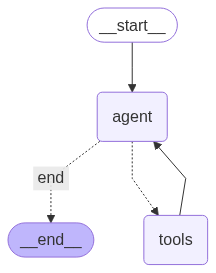

In [19]:
from IPython.display import Image, display
from io import BytesIO

image_data =graph.get_graph().draw_mermaid_png()
display(Image(image_data))

Test the Agent Locally

In [5]:
def test_agent_interaction(query: str):
    """Test a single interaction with the agent."""
    print(f"\n{'='*60}")
    print(f"🤖 Testing query: {query}")
    print(f"{'='*60}")
    
    result = graph.invoke({
        "messages": [HumanMessage(content=query)]
    })
    
    print("\n📋 Conversation History:")
    for i, message in enumerate(result["messages"]):
        message_type = type(message).__name__
        if hasattr(message, 'tool_calls') and message.tool_calls:
            print(f"{i+1}. {message_type}: [Called tools: {[tc['name'] for tc in message.tool_calls]}]")
        else:
            content = message.content[:100] + "..." if len(message.content) > 100 else message.content
            print(f"{i+1}. {message_type}: {content}")
    
    return result

# Test different types of queries
test_queries = [
    "What's the weather like in London?",
    "Calculate 25 * 14 + 100",
    "Search for information about LangGraph",
    "What's 15% of 240?"
]

print("🧪 Running test queries...")
for query in test_queries:
    test_agent_interaction(query)

🧪 Running test queries...

🤖 Testing query: What's the weather like in London?

📋 Conversation History:
1. HumanMessage: What's the weather like in London?
2. AIMessage: [Called tools: ['get_weather']]
3. ToolMessage: The weather in London is Cloudy with light rain, 15°C
4. AIMessage: The weather in London is currently cloudy with light rain, and the temperature is around 15°C.

🤖 Testing query: Calculate 25 * 14 + 100

📋 Conversation History:
1. HumanMessage: Calculate 25 * 14 + 100
2. AIMessage: [Called tools: ['calculate_math']]
3. ToolMessage: The result of 25 * 14 + 100 is 450
4. AIMessage: The result of the calculation \( 25 \times 14 + 100 \) is 450.

🤖 Testing query: Search for information about LangGraph

📋 Conversation History:
1. HumanMessage: Search for information about LangGraph
2. AIMessage: [Called tools: ['search_web']]
3. ToolMessage: Search results for 'LangGraph': Here are some relevant articles and information about LangGraph. Thi...
4. AIMessage: I found some info

Test different types of queries